In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import xarray as xr
from shapely import Polygon
import regionmask
import geopandas as gpd
import dask
from scipy.stats import circmean

In [2]:
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")

0.3.0


## Cairns

In [3]:
%%time
# above barra-2 varaiables is winds direction and speed at 850hPa, to compare to the station we want the near surface values
winds850 = barra_cairns.wind_dir.compute()
winds_dir850 = winds850[(winds850>=0)&(winds850<=90)]
wind_times850 = winds_dir850.time.values

# near surface:
def file_paths(variable):
    list = ["202201-202201","202202-202202","202101-202101","202102-202102","202103-202103","202104-202104","202001-202001","202002-202002",
           "202003-202003","202004-202004","201901-201901","201902-201902","201903-201903","201904-201904","201801-201801","201802-201802",
           "201803-201803","201804-201804","201701-201701","201702-201702","201703-201703","201704-201704","201601-201601","201602-201602",
           "201603-201603","201604-201604","201501-201501","201502-201502","201503-201503","201504-201504","201401-201401","201402-201402",
           "201403-201403","201404-201404","201301-201301","201302-201302","201303-201303","201304-201304","201201-201201","201202-201202",
           "201203-201203","201204-201204"]
    list.sort()
    file_paths = []
    for i in list:
        fp = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/"+variable+"/"
        all_files = [fp+variable+"_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_"+i+".nc"]
        file_paths.extend(all_files)
    file_paths.sort()
    return file_paths  
u_surface = file_paths("uas") # in m/s
v_surface = file_paths("vasmean") # in m/s
wind_speed = file_paths("sfcWind") # in m/s

def open_and_select(file_path,variable):
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:
        # towns = ds[variable].sel(lat=-19.4198,lon=146.5509,method="nearest").mean(dim=["time"]) # lat and lon are for radar site
        cairns = ds[variable].sel(lat=-16.8736,lon=145.7458,method="nearest")                     # lat and lon are for station site
        # willis = ds[variable].sel(lat=-16.2874,lon=149.9646,method="nearest").mean(dim=["time"]) # lat and lon are for radar site
        return (cairns*units("m/s")).compute()   #towns,willis 

uu = open_and_select(u_surface,"uas")
vv = open_and_select(v_surface,"vasmean")

wind_dir_barra = metpy.calc.wind_direction(uu,vv,convention='from')
wind_speed_barra = metpy.calc.wind_speed(uu,vv)

CPU times: user 16min 37s, sys: 58.8 s, total: 17min 35s
Wall time: 21min 6s


In [4]:
wind_dir_barra

Magnitude,[133.0925750732422 130.4164276123047 132.05392456054688 ... 276.8644104003906 295.22198486328125 307.6659851074219]
Units,degree


In [ ]:
def localTimeApprox(myDateTime, longitude):
   """Returns local hour approximation"""
   return myDateTime+dt.timedelta(hours=(longitude*12/180))

wind_dir_barra["time"] = localTimeApprox(wind_dir_barra["time"], 145.8)
wind_dir_barra

In [4]:
# Weather station - Cairns, file path
station_fp = '/g/data/w40/clv563/BoM_data/AWS-data-QLD.nc'
# open with xarray and dask chunking
station_ds = xr.open_dataset(station_fp, engine="h5netcdf", chunks="auto")
bmid_cairns = station_ds.bmid[21]     # BOM ID: 031011

# cairns
cairns_wdir = station_ds.wdir.sel(station=21) * units("degrees")
cairns_wspd = (station_ds.wspd.sel(station=21) * (1000/(60*60))) *  units("m/s")
cairns_precip = station_ds.prec.sel(station=21)
cairns_temp = station_ds.temp.sel(station=21)
cairns_mslp = station_ds.mslp.sel(station=21)

In [7]:
def JFMA_data(ds):
    var_jan_to_apr = [] # to append data
    years = np.arange(1990,2021,1) # available years of data
    for year in years:
        year_str = str(year)
        var_jfma = ds.sel(time=slice(year_str+'-01-01',year_str+'-04-30'))
        var_jan_to_apr.append(var_jfma)
    return xr.concat(var_jan_to_apr, dim='time').compute()
# cairns variables
wdirC = JFMA_data(cairns_wdir)
wspdC = JFMA_data(cairns_wspd)
precipC = JFMA_data(cairns_precip)
tempC = JFMA_data(cairns_temp)
mslpC = JFMA_data(cairns_mslp)

In [8]:
def wind_masks(ds_wdir,ds_wdspd):
    calm = ds_wdspd[ds_wdspd==0*units('m/s')]
    northerly = ds_wdir[ds_wdir==0*units('degrees')]
    calm_mask = xr.where(ds_wdspd==0*units('m/s'), np.nan, ds_wdspd)
    wdir_mask = xr.where(np.isnan(calm_mask), np.nan, ds_wdir)
    return wdir_mask,calm_mask
wdir_maskC,wspd_maskC = wind_masks(wdirC,wspdC)

In [11]:
def calc_mean_wdir(ds):
    radian = np.deg2rad(ds)
    circmean_ds = circmean(radian,high=(2*np.pi),low=0,nan_policy='omit')
    wdir_mean = np.rad2deg(circmean_ds)
    return wdir_mean
print('Mean Cairns wind direction: ',calc_mean_wdir(wdir_maskC))

Mean Cairns wind direction:  151.20350399645406


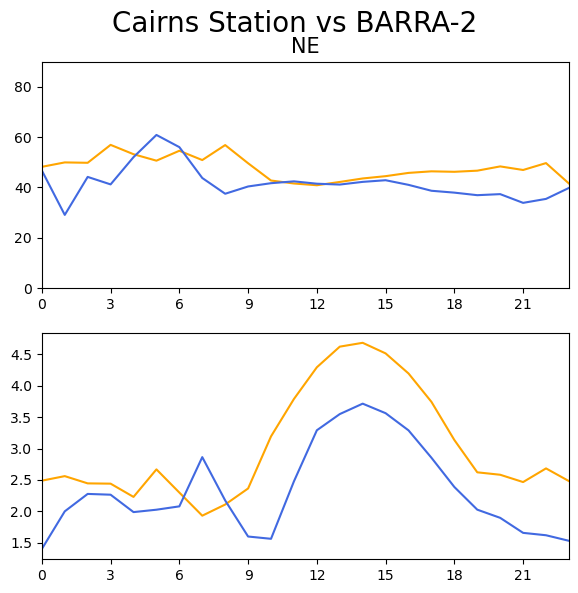

In [114]:
#plot diurnal cycle
fig,ax = plt.subplots(2,1, figsize=[6,6])
fig.patch.set_facecolor('white')
fig.suptitle('Cairns Station vs BARRA-2',fontsize=20)
fig.tight_layout()

# define station and barra wind direction and speed arrays for composites
# NE
station_winds_dirNE = wdir_maskC[(wdir_maskC>=0*units.degrees)&(wdir_maskC<=90*units.degrees)]
station_wind_timesNE = station_winds_dirNE.time.values
station_diurnal_meanNE = station_winds_dirNE.groupby(station_winds_dirNE.time.dt.hour).mean(dim="time")
ne = np.roll(station_diurnal_meanNE,shift=10)
ax[0].plot(np.arange(0,24,1),ne,color="orange") 
winds = wind_dir_barra.compute()
winds_dirNE = winds[(winds>=0*units.degrees)&(winds<=90*units.degrees)]
wind_timesNE = winds_dirNE.time.values
barra_diurnal_meanNE = winds_dirNE.groupby(winds_dirNE.time.dt.hour).mean(dim="time")
ne_barra =  np.roll(barra_diurnal_meanNE,shift=10)
ax[0].plot(np.arange(0,24,1),ne_barra,color="royalblue")
# wind speeds
station_wind_spds = wspd_maskC.sel(time=station_wind_timesNE).groupby(station_winds_dirNE.time.dt.hour).mean(dim="time")
station_wind_spdsNE = np.roll(station_wind_spds,shift=10)
ax[1].plot(np.arange(0,24,1),station_wind_spdsNE,color="orange")
wind_spds = wind_speed_barra.sel(time=wind_timesNE).groupby(winds_dirNE.time.dt.hour).mean(dim="time")
wind_spdsNE = np.roll(wind_spds,shift=10)
ax[1].plot(np.arange(0,24,1),wind_spdsNE,color="royalblue")

# SE
# station_winds_dirSE = wdir_maskC[(wdir_maskC>90*units.degrees)&(wdir_maskC<=180*units.degrees)]
# station_wind_timesSE = station_winds_dirSE.time.values
# station_diurnal_meanSE = station_winds_dirSE.groupby(station_winds_dirSE.time.dt.hour).mean(dim="time").plot(ax=ax[2,1])
# winds_dirSE = winds[(winds>90*units.degrees)&(winds<=180*units.degrees)]
# wind_timesSE = winds_dirSE.time.values
# barra_diurnal_meanSE = winds_dirSE.groupby(winds_dirSE.time.dt.hour).mean(dim="time").plot(ax=ax[2,1])
# # wind speeds
# station_wind_spds = wspd_maskC.sel(time=station_wind_timesSE).groupby(station_winds_dirSE.time.dt.hour).mean(dim="time").plot(ax=ax[3,1])
# wind_spds = wind_speed_barra.sel(time=wind_timesSE).groupby(winds_dirSE.time.dt.hour).mean(dim="time").plot(ax=ax[3,1])

# # SW
# station_winds_dirSW = wdir_maskC[(wdir_maskC>180*units.degrees)&(wdir_maskC<=270*units.degrees)]
# station_wind_timesSW = station_winds_dirSW.time.values
# station_diurnal_meanSW = station_winds_dirSW.groupby(station_winds_dirSW.time.dt.hour).mean(dim="time").plot(ax=ax[2,0])
# winds_dirSW = winds[(winds>180*units.degrees)&(winds<=270*units.degrees)]
# wind_timesSW = winds_dirSW.time.values
# barra_diurnal_meanSW = winds_dirSW.groupby(winds_dirSW.time.dt.hour).mean(dim="time").plot(ax=ax[2,0])
# # wind speeds
# station_wind_spds = wspd_maskC.sel(time=station_wind_timesSW).groupby(station_winds_dirSW.time.dt.hour).mean(dim="time").plot(ax=ax[3,0])
# wind_spds = wind_speed_barra.sel(time=wind_timesSW).groupby(winds_dirSW.time.dt.hour).mean(dim="time").plot(ax=ax[3,0])

# # NW
# station_winds_dirNW = wdir_maskC[(wdir_maskC>270*units.degrees)&(wdir_maskC<=360*units.degrees)]
# station_wind_timesNW = station_winds_dirNW.time.values
# station_diurnal_meanNW = station_winds_dirNW.groupby(station_winds_dirNW.time.dt.hour).mean(dim="time").plot(ax=ax[0,0])
# winds_dirNW = winds[(winds>270*units.degrees)&(winds<=360*units.degrees)]
# wind_timesNW = winds_dirNW.time.values
# barra_diurnal_meanNW = winds_dirNW.groupby(winds_dirNW.time.dt.hour).mean(dim="time").plot(ax=ax[0,0])
# # wind speeds
# station_wind_spds = wspd_maskC.sel(time=station_wind_timesNW).groupby(station_winds_dirNW.time.dt.hour).mean(dim="time").plot(ax=ax[1,0])
# wind_spds = wind_speed_barra.sel(time=wind_timesNW).groupby(winds_dirNW.time.dt.hour).mean(dim="time").plot(ax=ax[1,0])

# # titles and axis
# ax[0,0].set_title("NW",fontsize=15)
# ax[1,0].set_title("")
# ax[1,1].set_title("")
# ax[2,0].set_title("SW",fontsize=15)
# ax[3,0].set_title("")
# ax[3,1].set_title("")
ax[0].set_title("NE",fontsize=15)
# ax[2,1].set_title("SE",fontsize=15)

# ax[0,0].set_xlabel("")
# ax[1,0].set_xlabel("")
# ax[1,1].set_xlabel("")
# ax[2,0].set_xlabel("")
# ax[3,0].set_xlabel("Hour (AEST)")
# ax[3,1].set_xlabel("Hour (AEST)")
# ax[0,1].set_xlabel("")
# ax[2,1].set_xlabel("")

# # axis limits
# ax[0,0].set_ylim(270,360)
# ax[2,0].set_ylim(180,270)
ax[0].set_ylim(0,90)
# ax[2,1].set_ylim(90,180)
ax[0].set_xlim(0,23)
ax[1].set_xlim(0,23)
ax[0].set_xticks(np.arange(0,23,3))
ax[1].set_xticks(np.arange(0,23,3))

ax[0].barbs(range(len(wind_direction_degrees)), [0] * len(wind_direction_degrees), wind_speed * np.cos(wind_direction_radians), wind_speed * np.sin(wind_direction_radians),
          barb_increments=dict(half=2, full=4, flag=20), length=barb_length,pivot='middle',flip_barb=True)

In [ ]:
#plot diurnal cycle
fig,ax = plt.subplots(4,1, figsize=[6,6])
fig.patch.set_facecolor('white')
fig.suptitle('Cairns BoM Station',fontsize=20)
fig.tight_layout()

# plot wind direction as arrows
wind_direction_degrees = np.array(mean_hourly_wdir_AEST + 180)
wind_direction_radians = np.radians(90 - wind_direction_degrees)
wind_speed = np.array(mean_hourly_wspd_AEST_T)

# plot wind barbs
# barb_length = 5  # Adjust the barb length as needed
# ax[0].barbs(range(len(wind_direction_degrees)), [0] * len(wind_direction_degrees), wind_speed * np.cos(wind_direction_radians), wind_speed * np.sin(wind_direction_radians),
#           barb_increments=dict(half=2, full=4, flag=20), length=barb_length,pivot='middle',flip_barb=True)